# PyDVL - Shapley for data valuation

This notebook introduces Shapley methods for the computation of data value using pyDVL.

In order to show the practical advantages of shapley pydvl implementation, we will predict the popularity of songs in the "Top Hits Spotify from 2000-2019" dataset. While doing so, we will highlight how data valuation can help boost the performance of your models.

Here, all the library main entry-points will be briefly described. We will also show the advantages of this library compared to vanilla data-Shapley implementations, like runtime optimization for large datasets and models.

Let's start with some imports

In [2]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


To load the dataset, we will use the load_spotify_dataset method. Internally, the method will load data on songs published after 2014, use 30% of data for test, and another 30% of the remaining data for validation. Then, the method will return train, validation and test data as lists of the shape [X_input, Y_label]

In [3]:
from valuation.utils import load_spotify_dataset
train_data, val_data, test_data = load_spotify_dataset(val_size=0.3, test_size=0.3, target_column='popularity')
train_data[0].head()

/Users/fabio/miniconda3/envs/data_shapley/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,artist,song,duration_ms,explicit,year,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
1561,Fetty Wap,679 (feat. Remy Boyz),196693,True,2015,0.618,0.717,7,-5.738,1,0.3180,0.00256,0.000000,0.6250,0.603,190.050,8
1410,Meghan Trainor,All About That Bass,187920,True,2015,0.807,0.887,9,-3.726,1,0.0503,0.05730,0.000003,0.1240,0.961,134.052,14
1772,Katy Perry,Chained To The Rhythm,237733,False,2017,0.562,0.800,0,-5.404,1,0.1120,0.08140,0.000000,0.1990,0.471,95.029,14
1670,Sigala,Sweet Lovin' - Radio Edit,202149,False,2015,0.683,0.910,10,-1.231,1,0.0515,0.05530,0.000005,0.3360,0.674,124.977,15
1780,Liam Payne,Strip That Down,204502,False,2017,0.869,0.485,6,-5.595,1,0.0545,0.24600,0.000000,0.0765,0.527,106.028,14


The dataset has many high level feature, some quite intuitive ('duration_ms' or 'tempo'), and other a bit more cryptic ('valence'?). If you want more information on each feature, you can find it on [this webpage](https://www.kaggle.com/datasets/paradisejoy/top-hits-spotify-from-20002019?resource=download).
In our analysis, we will use all the columns, excluding 'artist' and 'song', to predict the 'popularity' of each song. We will nonetheless keep the information on song and artist in the train set in a separate pandas Series, for future reference.

In [4]:
song_name = train_data[0]['song']
artist = train_data[0]['artist']
train_data[0] = train_data[0].drop(['song', 'artist'], axis=1)
test_data[0] = test_data[0].drop(['song', 'artist'], axis=1)
val_data[0] = val_data[0].drop(['song', 'artist'], axis=1)

Input and label data need to be stored in a Dataset object, a pyDVL specific tool.

In [5]:
from valuation.utils import Dataset
dataset = Dataset(*train_data, *val_data)

The calculation of Shapley coefficients is very computationally expensive because it needs to go through several subsets of the original input dataset before converging. For this reason, the PyDVL library implements techniques to speed up the calculation, both caching intermediate results and allowing to group data to calculate Shapley values on groups instead of single-datapoints. From a Dataset object, you can just do the following.

In [6]:
from valuation.utils import GroupedDataset
grouped_dataset = GroupedDataset.from_dataset(dataset, artist)

And now we can finally calculate the contribution of each datapoint to the modle performance!

As model, we will use a GradientBoostingRegressor, but any model from sklearn, xgboost and lightgbm works. More precisely, any model that has a fit and predict method should run without issues.

Note: Make sure to restart (or simply start if it is not already running) your memcache. See our [documentation](https://appliedai-initiative.github.io/valuation/install.html) for details.

In [7]:
from valuation.shapley import get_shapley_values
from valuation.utils import Utility
from sklearn.ensemble import GradientBoostingRegressor

utility = Utility(
        model=GradientBoostingRegressor(n_estimators=3), data=grouped_dataset, scoring='neg_mean_absolute_error', enable_cache=True,
    )
dvl_df = get_shapley_values(utility, max_iterations=100, num_workers=8)

2022-08-17 09:33:13,895	WARNING actor.py:442 -- Creating an actor from class ActorClass(ShapleyCoordinator) overwrites attribute remote of that class
2022-08-17 09:33:13,897	WARNING actor.py:442 -- Creating an actor from class ActorClass(ShapleyCoordinator) overwrites attribute _remote of that class
2022-08-17 09:33:13,897	WARNING actor.py:442 -- Creating an actor from class ActorClass(ShapleyCoordinator) overwrites attribute _ray_from_modified_class of that class
2022-08-17 09:33:13,898	WARNING actor.py:442 -- Creating an actor from class ActorClass(ShapleyCoordinator) overwrites attribute _ray_from_function_descriptor of that class


TypeError: Cannot create a consistent method resolution
order (MRO) for bases ActorClass, ActorClass(ShapleyCoordinator)

As you can see, the first object that we have defined (utility) holds all the information on the dataset, the model and the scoring methods. Within utility, the PyDVL library uses a cache to speed up calculation of the Shapley coefficients.
The second method, get_shapley_values, calculates the actual Shapley values and manages parallelization. Let's take a look at the returned dataframe.

In [ ]:
dvl_df.head()

,data_key,shapley_dval,dval_std
0,Shawn Mendes,-0.776832,0.022177
1,Maroon 5,-0.726442,0.048680
2,Kendrick Lamar,-0.714844,0.024770
3,Fedde Le Grand,-0.677533,0.024429
4,Reik,-0.645688,0.078413


The first thing to notice is that the dvl_df dataframe is sorted in ascending order of shapley values. The data_key columns holds the labels for each data group: in this case, since the groups correspond to artists, it coincides with artist names. The second column corresponds to the shapley data valuation score, and the third to its (approximate) standard deviation.

A better way to analyse the results is through a plot. In the next cell we will take the 30 datapoints with lowest score and plot them with errorbars

/var/folders/kj/nzr59d991gj0y17m_d24hfyr0000gn/T/ipykernel_98899/1298377207.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


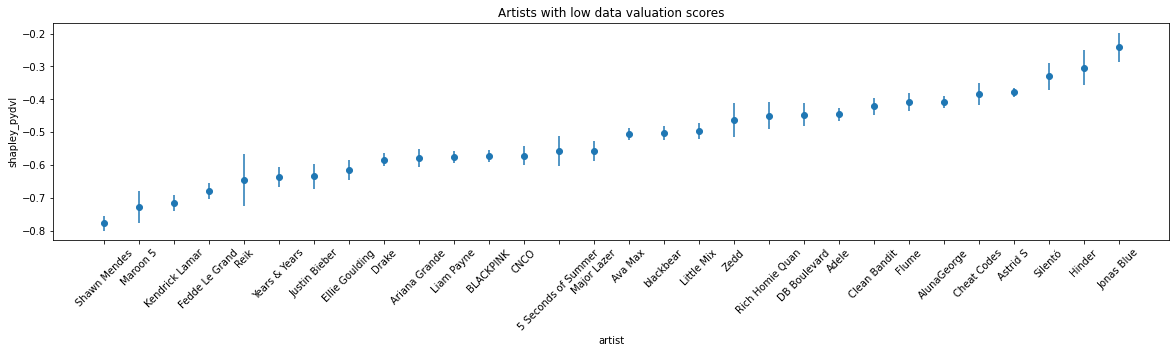

In [ ]:
from valuation.utils import plot_shapley
low_dvl = dvl_df.iloc[:30]
fig = plot_shapley(low_dvl, figsize=(20, 4), title='Artists with low data valuation scores', xlabel='artist', ylabel='shapley_pydvl')
fig.show()

As you can see, there are a lot of points which give negative shapley score, meaning that they tend to decrease the total score of the model when present in the training set! What happens if we remove it? In the next cell we will create a new training set which excludes the 30 points with lowest scores.

In [ ]:
low_dvl_artists = dvl_df.iloc[:30].data_key.to_list()
artist_filter = ~artist.isin(low_dvl_artists)
X_train_good_dvl = train_data[0][artist_filter]
y_train_good_dvl = train_data[1][artist_filter]

Now we will use this cleaned dataset to train a full GradientBoostingRegressor and compare its mean absolute error to the model which uses the full dataset. Notice that the score now is calculated using the test set, while for calculating the shapley values we were using the validation set.

In [ ]:
from sklearn.metrics import mean_absolute_error
full_model = GradientBoostingRegressor(n_estimators=3).fit(X_train_good_dvl, y_train_good_dvl)
mean_absolute_error(full_model.predict(test_data[0]), test_data[1])

17.001722356968248

In [ ]:
full_model = GradientBoostingRegressor(n_estimators=3).fit(train_data[0], train_data[1])
mean_absolute_error(full_model.predict(test_data[0]), test_data[1])

19.49470900052308

The score has improved by more than 15%! This is quite an important result, as it shows a self-consistent process to improve the performance of a model by excluding datapoints from its training set.

## Evaluation on anomalous data

Another interesting test is to corrupt some of the data and monitor how their valuation score changes. To do this, we will take one of the authors with the highest score and set all its popularity to 0.

/var/folders/kj/nzr59d991gj0y17m_d24hfyr0000gn/T/ipykernel_98899/3974558511.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


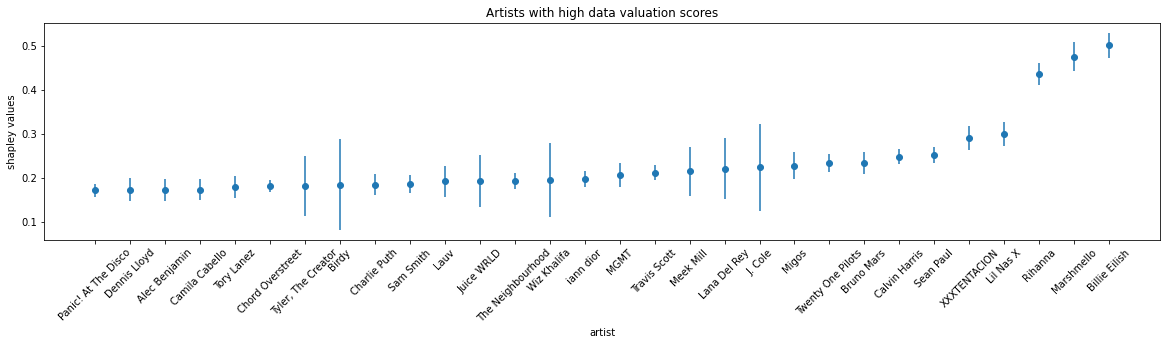

In [ ]:
high_dvl = dvl_df.iloc[-30:]
fig = plot_shapley(high_dvl, figsize=(20, 4), title='Artists with high data valuation scores', xlabel='artist', ylabel='shapley values')
fig.show()

From the plot above, we can see that Rihanna has one of the highest scores. Let's now take all the train labels related to her, set the score to 0 and re-calculate the data valuation scores. Notice that I must use a new name for the dataset, because I need to create another cache. Reusing the old one would be a mistake since modifying even just one label changes all the shapley values.

In [ ]:
train_data[1].loc[artist == 'Rihanna'] = 0
dataset = Dataset(*train_data, *val_data)
grouped_dataset = GroupedDataset.from_dataset(dataset, artist)
utility = Utility(
        model=GradientBoostingRegressor(n_estimators=3), data=grouped_dataset, scoring='neg_mean_absolute_error', enable_cache=True,
    )
dvl_df = get_shapley_values(utility, max_iterations=100, num_workers=8)

(pid=98949) 2022-08-17 09:20:26,352	WARNING actor.py:442 -- Creating an actor from class ShapleyCoordinator overwrites attribute remote of that class
(pid=98949) 2022-08-17 09:20:26,353	WARNING actor.py:442 -- Creating an actor from class ShapleyWorker overwrites attribute remote of that class
(pid=98953) 2022-08-17 09:20:26,336	WARNING actor.py:442 -- Creating an actor from class ShapleyCoordinator overwrites attribute remote of that class
(pid=98953) 2022-08-17 09:20:26,338	WARNING actor.py:442 -- Creating an actor from class ShapleyWorker overwrites attribute remote of that class
(pid=98952) 2022-08-17 09:20:26,310	WARNING actor.py:442 -- Creating an actor from class ShapleyCoordinator overwrites attribute remote of that class
(pid=98952) 2022-08-17 09:20:26,312	WARNING actor.py:442 -- Creating an actor from class ShapleyWorker overwrites attribute remote of that class
(pid=98951) 2022-08-17 09:20:26,354	WARNING actor.py:442 -- Creating an actor from class ShapleyCoordinator overwri

Let's now take the low scoring artists and plot the results

/var/folders/kj/nzr59d991gj0y17m_d24hfyr0000gn/T/ipykernel_98899/1035400712.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


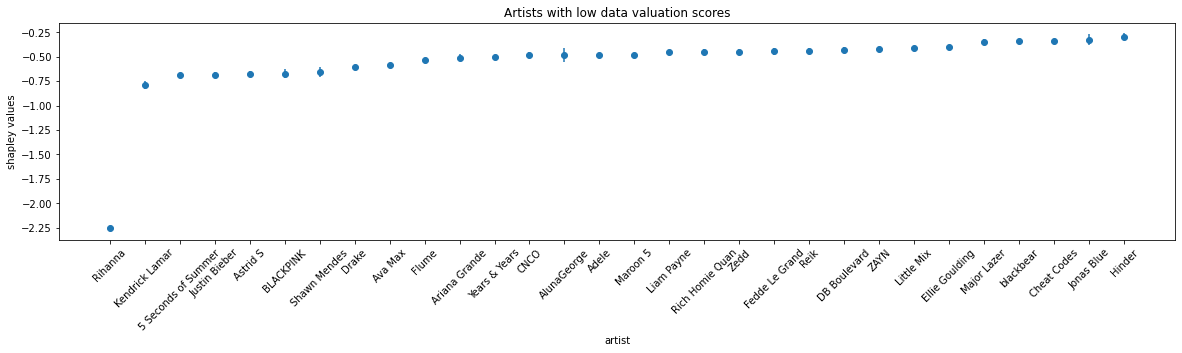

In [ ]:
low_dvl = dvl_df.iloc[:30]
fig = plot_shapley(low_dvl, figsize=(20, 4), title='Artists with low data valuation scores', xlabel='artist', ylabel='shapley values')
fig.show()

And Rihanna (our anomalous data group) has moved from top contributor to having negative impact on the performance of the model, as expected!